In [1]:
# ============================================
# Imports
# ============================================
from transformers import BertForSequenceClassification, BertTokenizer, AutoConfig
from lime.lime_text import LimeTextExplainer
from lime.explanation import Explanation
from scipy.stats import spearmanr
from scipy.special import comb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import Ridge
from nltk.corpus import stopwords
from tqdm import tqdm  # ✅ 여기에 추가!
from typing import List, Dict

import pandas as pd
import numpy as np
import shap
import torch
import os
import re
import pickle
import glob
import gc

In [2]:
# %%
class Config:
    """전역 설정"""
    
    MODEL_PATH = "../checkpoints/checkpoint-22590/"
    CSV_PATH = "../data/sample_balanced_eval_set.csv"
    OUTPUT_DIR = "sample"
    
    DISPLAY_LABELS = ["bug", "enhancement", "question"]
    TEXT_COL_TITLE = "issue_title"
    TEXT_COL_BODY = "issue_body"
    GOLD_COL = "issue_label"
    MAX_CHARS = 500
    
    # LIME 최적화 설정
    LIME_NUM_FEATURES = 100
    # LIME_NUM_SAMPLES = 5000  # 더 많은 샘플로 안정성 향상
    LIME_KERNEL_WIDTH = 25  # 텍스트 기본값
    LIME_BOW = True  # Bag of words (단어 순서 무시)
    LIME_FEATURE_SELECTION = 'auto'  # forward_selection, lasso_path, auto
    
    
    BATCH_SIZE = 100  # 100개씩 처리 후 저장
    SAVE_EXPLANATIONS = False  # Explanation 객체 저장 안 함 (메모리 절약)
    # SHAP 설정
    SHAP_MAX_EVALS = 1000
    
    # Faithfulness 설정
    FAITHFULNESS_KS = [5, 10, 20]
config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)


In [3]:
import re
WORD_RE = re.compile(r"\w+")

def word_tokens(text):
    return [m.group() for m in WORD_RE.finditer(text)]

def word_spans(text):
    return [m.span() for m in WORD_RE.finditer(text)]

In [4]:
import re

def clean_for_lime(text: str) -> str:
    # HTML, markdown, 한자/한글/러시아어/중국어 제거
    text = re.sub(r"<[^>]+>", " ", text)         # HTML 태그 제거
    text = re.sub(r"[^\x00-\x7F]+", " ", text)   # ASCII 외 문자 제거
    text = re.sub(r"\s+", " ", text)             # 공백 정리
    return text.strip()

In [40]:
class ExplanationStorage:
    def __init__(self):
        self.lime_dir = f"{config.OUTPUT_DIR}"
        self.shap_dir = f"{config.OUTPUT_DIR}"  # ← 통일
        # 개별 cache 폴더 생성 안 함!
    
    # ✅ LIME: 배치 파일에서 읽기
    def get_lime(self, idx: int):
        """배치 파일에서 LIME Explanation 읽기"""
        batch_num = idx // config.BATCH_SIZE
        
        pkl_path = f"{self.lime_dir}/lime_cache/lime_batch_{batch_num}.pkl"
        if not os.path.exists(pkl_path):
            pkl_path = f"{self.lime_dir}/lime_cache/lime_batch_final.pkl"
        
        try:
            with open(pkl_path, "rb") as f:
                batch = pickle.load(f)
            
            for item in batch:
                if item['i'] == idx:
                    return item['explanation']
            return None
        except Exception as e:
            print(f"⚠️ Failed to load LIME {idx}: {e}")
            return None
    
    # ✅ SHAP: 배치 파일에서 읽기 (새로 추가!)
    def get_shap(self, idx: int):
        """배치 파일에서 SHAP Explanation 읽기"""
        batch_num = idx // config.BATCH_SIZE
        
        pkl_path = f"{self.shap_dir}/shap_cache/shap_batch_{batch_num}.pkl"
        if not os.path.exists(pkl_path):
            pkl_path = f"{self.shap_dir}/shap_cache/shap_batch_final.pkl"
        
        try:
            with open(pkl_path, "rb") as f:
                batch = pickle.load(f)
            
            for item in batch:
                if item['i'] == idx:
                    return item['explanation']
            return None
        except Exception as e:
            print(f"⚠️ Failed to load SHAP {idx}: {e}")
            return None
        
# %%
class ModelManager:
    """모델 로딩 및 예측 관리"""
    
    def __init__(self, model_path: str, display_labels: List[str]):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        model_config = AutoConfig.from_pretrained(model_path)
        self.model = BertForSequenceClassification.from_pretrained(model_path, config=model_config)
        self.tokenizer = BertTokenizer.from_pretrained(model_path)
        self.model.to(self.device)
        self.model.eval()
        
        if getattr(self.model.config, "id2label", None):
            raw = [self.model.config.id2label[i] for i in range(self.model.config.num_labels)]
            self.labels = display_labels if set(raw) == {f"LABEL_{i}" for i in range(len(raw))} else raw
        else:
            self.labels = display_labels
            
        assert len(self.labels) == self.model.config.num_labels
        print(f"Labels: {self.labels}")
    
    def predict(self, texts: List[str]) -> np.ndarray:
        """텍스트 리스트에 대한 예측 확률 반환 (SHAP/NumPy 입력 안전 처리)"""
    
        def _to_pystr(x):
            if x is None or (isinstance(x, float) and np.isnan(x)):
                return ""
            if isinstance(x, bytes):
                return x.decode("utf-8", errors="ignore")
            return str(x)
    
        def _coerce_to_list_of_str(x):
            # numpy array인 경우
            if isinstance(x, np.ndarray):
                # 2D: (num_variants, num_tokens) → 각 행을 공백으로 join
                if x.ndim == 2:
                    return [" ".join(_to_pystr(tok) for tok in row.tolist() if _to_pystr(tok) != "")
                            for row in x]
                # 1D: 요소가 리스트/배열이면 join, 아니면 str
                x = x.tolist()
    
            # 리스트/튜플 처리
            if isinstance(x, (list, tuple)):
                out = []
                for item in x:
                    if isinstance(item, (list, tuple, np.ndarray)):
                        if isinstance(item, np.ndarray):
                            item = item.tolist()
                        out.append(" ".join(_to_pystr(tok) for tok in item if _to_pystr(tok) != ""))
                    else:
                        out.append(_to_pystr(item))
                return out
    
            # 단일 값
            return [_to_pystr(x)]
    
        texts = _coerce_to_list_of_str(texts)
    
        enc = self.tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        enc = {k: v.to(self.device) for k, v in enc.items()}
    
        with torch.no_grad():
            logits = self.model(**enc).logits
            probs  = torch.softmax(logits, dim=-1).cpu().numpy()
        return probs

In [41]:
class DataLoader:
    """데이터 로딩 및 전처리"""
    
    def __init__(self, csv_path: str, config: Config):
        chosen_path = None
        candidates = [csv_path, os.path.join('data', csv_path)]
        for p in candidates:
            if os.path.exists(p):
                chosen_path = p
                break
        if chosen_path is None:
            available = []
            if os.path.exists('data'):
                available = [f for f in os.listdir('data') if f.lower().endswith('.csv')]
            raise FileNotFoundError(
                f"{csv_path} not found. Update Config.CSV_PATH or choose from data/: {available}"
            )
        
        self.df = pd.read_csv(chosen_path).reset_index(drop=True)
        self.config = config
        print(f"Loaded {len(self.df)} samples")
        print(f"Label distribution:\n{self.df[config.GOLD_COL].value_counts()}")
        
    def build_text(self, row) -> str:
        """행 데이터로부터 텍스트 생성 (제목+본문 총 길이 제한 버전)"""
        title = str(row.get(self.config.TEXT_COL_TITLE, "")).strip()
        body = str(row.get(self.config.TEXT_COL_BODY, "")).strip()
    
        # 완전히 비어 있으면 기본 문장 반환
        if not title and not body:
            return "empty document"
    
        max_chars = getattr(self.config, "MAX_CHARS", 500)
    
        # ✅ 제목+본문을 합쳐서 길이 제한 적용
        combined = f"{title}\n\n{body}" if title and body else (title or body)
    
        if len(combined) > max_chars:
            # print(f"[warn] Text truncated from {len(combined)} to {max_chars} chars")
            combined = combined[:max_chars].rstrip()
    
        return combined

    
    def get_samples(self) -> List[str]:
        """전체 샘플 텍스트 반환"""
        return [self.build_text(row) for _, row in self.df.iterrows()]



# %%
# Initialize
model_manager = ModelManager(config.MODEL_PATH, config.DISPLAY_LABELS)
data_loader = DataLoader(config.CSV_PATH, config)
samples = data_loader.get_samples()
# print(samples)

# %% [markdown]
## LIME Analysis - API 기반 최적화

# %%
print("="*60)
print("Running LIME Analysis (Optimized)...")
print("="*60)

Using device: cuda


C:\Users\HJE\anaconda3\envs\issueBERT\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Labels: ['bug', 'enhancement', 'question']
Loaded 6 samples
Label distribution:
issue_label
bug            2
enhancement    2
question       2
Name: count, dtype: int64
Running LIME Analysis (Optimized)...


In [42]:
print("=" * 60)
print("Running LIME Analysis...")
print("=" * 60)

from nltk.corpus import stopwords
import os

STOPWORDS = set(stopwords.words("english"))
KEEP_WORDS = {"not", "no", "must", "should", "need", "cannot", "won't", "would", "could", "will"}
STOPWORDS = STOPWORDS - KEEP_WORDS

lime_explainer = LimeTextExplainer(
    class_names=model_manager.labels,
    split_expression=r"\W+",
    bow=config.LIME_BOW,
    mask_string=model_manager.tokenizer.mask_token,
    kernel_width=config.LIME_KERNEL_WIDTH,
    feature_selection=config.LIME_FEATURE_SELECTION,
    random_state=42
)

lime_results_batch = []
lime_pickle_batch = []


def preprocess_for_lime(txt):
    """불용어 제거 (SHAP과 동일)"""
    toks = [t for t in re.findall(r"\w+", txt) if t.lower() not in STOPWORDS]
    return " ".join(toks)


csv_path = f"{config.OUTPUT_DIR}/lime_results_raw.csv"

for i, txt_original in enumerate(samples):
    try:
        txt_filtered = preprocess_for_lime(txt_original)

        tokens = [t for t in re.findall(r"\w+", txt_filtered) if t.strip()]
        n_tokens = len(tokens)

        probs = model_manager.predict([txt_original])[0]
        idx = int(probs.argmax())
        predlab = model_manager.labels[idx]
        goldlab = data_loader.df.iloc[i][config.GOLD_COL]

        print(f"[LIME {i:04d}/{len(samples)}] real: {goldlab} | pred: {predlab} (conf: {probs[idx]:.3f})")

        exp = lime_explainer.explain_instance(
            text_instance=txt_filtered,
            classifier_fn=model_manager.predict,
            labels=[idx],
            num_features=n_tokens,
            num_samples=1000,
            distance_metric='cosine'
        )

        features = exp.as_list(label=idx)

        lime_results_batch.append({
            "i": i,
            "gold": goldlab,
            "pred": predlab,
            "pred_prob": float(probs[idx]),
            "features": str(features)
        })

        lime_pickle_batch.append({
            "i": i,
            "explanation": exp,
            "tokens": tokens,
            "features": features,
            "pred_class": idx,
            "pred_prob": float(probs[idx])
        })

        # ✅✅✅ 배치 저장 (수정: 마지막도 포함!)
        if (i + 1) % config.BATCH_SIZE == 0 or (i + 1) == len(samples):
            # CSV 저장
            if lime_results_batch:
                df_batch = pd.DataFrame(lime_results_batch)
                file_exists = os.path.exists(csv_path)
                mode = 'a' if file_exists else 'w'
                header = not file_exists
                df_batch.to_csv(csv_path, mode=mode, header=header, index=False)
                print(f"    CSV: {len(lime_results_batch)} rows (mode={mode}, header={header})")
                lime_results_batch = []


            # Pickle 저장
            if lime_pickle_batch:
                batch_num = i // config.BATCH_SIZE
                pkl_name = f"lime_batch_{batch_num}.pkl" if (i + 1) < len(samples) else "lime_batch_final.pkl"
                
                # ✅ 폴더 생성
                pkl_dir = f"{config.OUTPUT_DIR}/lime_cache"
                os.makedirs(pkl_dir, exist_ok=True)
                
                with open(f"{pkl_dir}/{pkl_name}", "wb") as f:
                    pickle.dump(lime_pickle_batch, f)
                print(f"    PKL: {pkl_name} ({len(lime_pickle_batch)} explanations)")
                lime_pickle_batch = []
            
            torch.cuda.empty_cache()
            gc.collect()
            print(f"  ✅ Batch saved: {i + 1}/{len(samples)}")

    except Exception as e:
        print(f"❌ [LIME {i:04d}] Error: {e}")
        goldlab = data_loader.df.iloc[i][config.GOLD_COL]

        dummy_exp = Explanation(domain_mapper=None, mode='classification')

        lime_results_batch.append({
            "i": i,
            "gold": goldlab,
            "pred": "error",
            "pred_prob": 0.0,
            "features": "[]"
        })

        lime_pickle_batch.append({
            "i": i, 
            "explanation": dummy_exp,
            "tokens": [],
            "features": [],
            "pred_class": -1,
            "pred_prob": 0.0
        })
        continue

print(f"\n✅ LIME analysis complete")
print(f"   CSV: {csv_path}")
print(f"   Pickle batches: {config.OUTPUT_DIR}/lime_batch_*.pkl")

Running LIME Analysis...
[LIME 0000/6] real: bug | pred: bug (conf: 1.000)
[LIME 0001/6] real: bug | pred: bug (conf: 1.000)
[LIME 0002/6] real: enhancement | pred: enhancement (conf: 1.000)
[LIME 0003/6] real: enhancement | pred: enhancement (conf: 0.988)
[LIME 0004/6] real: question | pred: question (conf: 0.960)
[LIME 0005/6] real: question | pred: enhancement (conf: 0.735)
    CSV: 6 rows (mode=w, header=True)
    PKL: lime_batch_final.pkl (6 explanations)
  ✅ Batch saved: 6/6

✅ LIME analysis complete
   CSV: sample/lime_results_raw.csv
   Pickle batches: sample/lime_batch_*.pkl


In [43]:
print("=" * 60)
print("Running SHAP Analysis (Word-level) - KernelSHAP")
print("=" * 60)

import numpy as np
import pickle
from scipy.special import comb
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))
KEEP_WORDS = {"not", "no", "must", "should", "need", "cannot", "won't", "would", "could", "will"}
STOPWORDS = STOPWORDS - KEEP_WORDS


def tokenize_and_filter(text):
    tokens = word_tokens(text)
    return [t for t in tokens if t.lower() not in STOPWORDS]


def compute_shap_values_kernel(text, tokens, max_evals=1000):
    """KernelSHAP: Weighted linear regression으로 Shapley value 근사"""
    from sklearn.linear_model import Ridge

    n_tokens = len(tokens)
    full_text = " ".join(tokens)
    base_probs = model_manager.predict([full_text])[0]

    # Coalition 샘플링
    np.random.seed(42)
    n_samples = min(max_evals, 2 ** n_tokens)

    coalitions = []
    batch_texts = []

    for _ in range(n_samples):
        coalition = np.random.rand(n_tokens) > 0.5
        coalitions.append(coalition)

        coalition_tokens = [tokens[i] if coalition[i] else "[MASK]"
                            for i in range(n_tokens)]
        batch_texts.append(" ".join(coalition_tokens))

    predictions = model_manager.predict(batch_texts)

    # Weighted Linear Regression
    X = np.array(coalitions, dtype=float)
    shap_values = np.zeros((n_tokens, 3))

    for class_idx in range(3):
        y = predictions[:, class_idx]
        coalition_sizes = X.sum(axis=1)

        weights = np.zeros(n_samples)
        for i, size in enumerate(coalition_sizes):
            if size == 0 or size == n_tokens:
                weights[i] = 1000
            else:
                weights[i] = (n_tokens - 1) / (
                        comb(n_tokens, size, exact=True) * size * (n_tokens - size)
                )

        weights = np.clip(weights, 1e-6, 1e6)

        model = Ridge(alpha=0.01)
        model.fit(X, y, sample_weight=weights)

        shap_values[:, class_idx] = model.coef_

    return shap_values, base_probs


# ✅ SHAP 계산
shap_results_batch = []  # Pickle용 (Explanation 객체 포함)
shap_csv_batch = []      # CSV용

csv_path = f"{config.OUTPUT_DIR}/shap_results_raw.csv"

for i in range(len(samples)):
    try:
        txt = samples[i]
        tokens = tokenize_and_filter(txt)
        n_tokens = len(tokens)

        if n_tokens == 0:
            print(f"[SHAP {i:04d}/{len(samples)}] ⚠️ No tokens")

            # Dummy Explanation
            dummy = shap.Explanation(
                values=np.zeros((0, 3)),
                base_values=np.array([0.33, 0.33, 0.34]),
                data=np.array([], dtype=object),
            )
            dummy.output_names = config.DISPLAY_LABELS

            # ✅ 배치에 추가
            shap_results_batch.append({
                "i": i,
                "explanation": dummy,
                "tokens": [],
                "values": np.zeros((0, 3)).tolist(),
                "base_values": [0.33, 0.33, 0.34],
                "pred_class": -1,
                "pred_prob": 0.0
            })

            continue

        # KernelSHAP 계산
        values, base_values = compute_shap_values_kernel(txt, tokens, max_evals=config.SHAP_MAX_EVALS)

        # Explanation 객체 생성
        explanation = shap.Explanation(
            values=values,
            base_values=base_values,
            data=np.array(tokens, dtype=object),
        )
        explanation.output_names = config.DISPLAY_LABELS

        # 원본 텍스트로 예측
        probs = model_manager.predict([txt])[0]
        cls = int(np.argmax(probs))
        goldlab = data_loader.df.iloc[i][config.GOLD_COL]

        # ✅ Pickle용 데이터 (Explanation 객체 포함!)
        shap_results_batch.append({
            "i": i,
            "explanation": explanation,  # ← Explanation 객체 (Faithfulness용)
            "tokens": tokens,
            "values": values.tolist(),
            "base_values": base_values.tolist(),
            "pred_class": cls,
            "pred_prob": float(probs[cls])
        })

        # ✅ CSV용 데이터
        shap_csv_batch.append({
            "i": i,
            "gold": goldlab,
            "pred": model_manager.labels[cls],
            "pred_prob": float(probs[cls]),
            "tokens": str(tokens),
            "values": str(values.tolist())
        })

        values_sum = np.abs(values).sum()
        print(f"[SHAP {i:04d}/{len(samples)}] ✅ ({n_tokens} tokens) | sum: {values_sum:.4f}")

        # ✅✅✅ 배치 저장 (수정: 마지막도 포함!)
        if (i + 1) % config.BATCH_SIZE == 0 or (i + 1) == len(samples):
            # Pickle 저장
            if shap_results_batch:
                batch_num = i // config.BATCH_SIZE
                pkl_name = f"shap_batch_{batch_num}.pkl" if (i + 1) < len(samples) else "shap_batch_final.pkl"
                
                # ✅ 폴더 생성
                pkl_dir = f"{config.OUTPUT_DIR}/shap_cache"
                os.makedirs(pkl_dir, exist_ok=True)
                
                with open(f"{pkl_dir}/{pkl_name}", "wb") as f:
                    pickle.dump(shap_results_batch, f)
                print(f"    PKL: {pkl_name} ({len(shap_results_batch)} explanations)")
                shap_results_batch = []

            # CSV 저장
            if shap_csv_batch:
                df_batch = pd.DataFrame(shap_csv_batch)
                file_exists = os.path.exists(csv_path)
                mode = 'a' if file_exists else 'w'
                header = not file_exists
                df_batch.to_csv(csv_path, mode=mode, header=header, index=False)
                print(f"    CSV: {len(shap_csv_batch)} rows (mode={mode}, header={header})")
                shap_csv_batch = []

            torch.cuda.empty_cache()
            gc.collect()
            print(f"  ✅ Batch saved: {i + 1}/{len(samples)}")

    except Exception as e:
        print(f"❌ [SHAP {i:04d}] error: {e}")
        import traceback
        traceback.print_exc()
        torch.cuda.empty_cache()
        gc.collect()
        continue

print(f"\n✅ SHAP analysis complete")
print(f"   Pickle batches: {config.OUTPUT_DIR}/shap_cache/shap_batch_*.pkl")
print(f"   CSV summary: {config.OUTPUT_DIR}/shap_results_raw.csv")

Running SHAP Analysis (Word-level) - KernelSHAP
[SHAP 0000/6] ✅ (61 tokens) | sum: 0.0228
[SHAP 0001/6] ✅ (62 tokens) | sum: 0.0023
[SHAP 0002/6] ✅ (54 tokens) | sum: 0.1351
[SHAP 0003/6] ✅ (9 tokens) | sum: 2.5254
[SHAP 0004/6] ✅ (52 tokens) | sum: 0.1221
[SHAP 0005/6] ✅ (47 tokens) | sum: 0.1402
    PKL: shap_batch_final.pkl (6 explanations)
    CSV: 6 rows (mode=w, header=True)
  ✅ Batch saved: 6/6

✅ SHAP analysis complete
   Pickle batches: sample/shap_cache/shap_batch_*.pkl
   CSV summary: sample/shap_results_raw.csv


In [44]:
def predict_texts_for_shap(text_list):
    """SHAP용 예측 함수: 디버깅 포함"""
    print(f"\n[DEBUG predict_texts_for_shap]")
    print(f"  - type(text_list): {type(text_list)}")
    print(f"  - len(text_list): {len(text_list)}")
    
    if len(text_list) > 0:
        print(f"  - type(text_list[0]): {type(text_list[0])}")
        print(f"  - text_list[0][:100]: {str(text_list[0])[:100]}")
    
    clean_texts = []
    for idx, txt in enumerate(text_list):
        # ✅ bytes 처리
        if isinstance(txt, (bytes, np.bytes_)):
            txt = txt.decode("utf-8", errors="ignore")
            print(f"  [{idx}] Decoded from bytes")
        # ✅ 리스트인 경우 조인
        elif isinstance(txt, (list, np.ndarray)):
            print(f"  [{idx}] Joining list/array of length {len(txt)}")
            txt = " ".join([str(t) for t in txt if str(t).strip()])
        else:
            txt = str(txt)
        
        print(f"  [{idx}] Final text: {txt[:100]}")
        clean_texts.append(txt)
    
    result = model_manager.predict(clean_texts)
    print(f"  - result.shape: {result.shape if hasattr(result, 'shape') else len(result)}")
    return result

In [45]:

# %%

def mask_words_by_spans(text, word_indices, keep=False):
    spans = word_spans(text)
    mask_set = set(word_indices)
    out, last = [], 0
    
    for i, (s, e) in enumerate(spans):
        out.append(text[last:s])
        
        # ✅ 수정: keep=False면 mask_set에 있는 것 마스킹
        #          keep=True면 mask_set에 없는 것 마스킹
        should_mask = (i in mask_set and not keep) or (i not in mask_set and keep)
        out.append(model_manager.tokenizer.mask_token if should_mask else text[s:e])
        
        last = e
    out.append(text[last:])
    return ''.join(out)
def predict_with_word_mask(text, mask_indices, keep=False):
    masked_text = mask_words_by_spans(text, mask_indices, keep)
    return model_manager.predict([masked_text])[0]


def topk_word_indices(values: np.ndarray, k: int = 10) -> List[int]:
    """상위 k개 단어 인덱스 반환"""
    order = np.argsort(-np.abs(values))
    return order[:min(k, len(order))].tolist()

def log_odds(prob: float) -> float:
    """Return true log-odds (logit)"""
    return float(np.log(max(prob, 1e-10) / max(1 - prob, 1e-10)))

In [46]:
def topk_indices_from_word_features(text, ranked_word_features, k):
    toks = [t.lower() for t in word_tokens(text)]
    picked, used = [], set()
    for w, _ in ranked_word_features:  # abs(score) desc
        target = w.lower()
        for i, t in enumerate(toks):
            if t == target and i not in used:
                picked.append(i); used.add(i)
                if len(picked) == k:
                    return picked
    return picked


In [47]:

def shap_faithfulness_metrics(text: str, sv, k: int = 10) -> Dict:
    """SHAP faithfulness 계산 - 토큰 기준 통일"""
    # ✅ 필터링된 토큰으로 통일
    tokens = tokenize_and_filter(text)
    filtered_text = " ".join(tokens)
    
    base_probs = model_manager.predict([filtered_text])[0]
    yhat = int(np.argmax(base_probs))
    p_full = float(base_probs[yhat])
    
    values = sv.values[:, yhat]
    topk_idx = topk_word_indices(values, k=k)
    
    # ✅ 필터링된 토큰으로 마스킹
    p_drop_tokens = [tokens[i] if i not in topk_idx else "[MASK]" 
                     for i in range(len(tokens))]
    p_drop = float(model_manager.predict([" ".join(p_drop_tokens)])[0][yhat])
    
    p_keep_tokens = [tokens[i] if i in topk_idx else "[MASK]" 
                     for i in range(len(tokens))]
    p_keep = float(model_manager.predict([" ".join(p_keep_tokens)])[0][yhat])
    
    comprehensiveness = p_full - p_drop
    sufficiency = p_full - p_keep
    
    lor_drop = float(np.log(max(p_drop, 1e-10) / max(p_full, 1e-10)))
    lor_keep = float(np.log(max(p_keep, 1e-10) / max(p_full, 1e-10)))
    
    return {
        "method": "shap",
        "pred_class": model_manager.labels[yhat],
        "p_full": p_full,
        "p_drop": p_drop,
        "p_keep": p_keep,
        "comprehensiveness": comprehensiveness,
        "sufficiency": sufficiency,
        "log_odds_drop": lor_drop,
        "log_odds_keep": lor_keep
    }

def lime_faithfulness_metrics(text: str, exp, label_idx: int, k: int = 10) -> Dict:
    """LIME faithfulness 계산 (단어 단위)"""
    base_probs = model_manager.predict([text])[0]
    yhat = int(np.argmax(base_probs))
    p_full = float(base_probs[yhat])
    
    # 상위 K 단어 인덱스 추출
    lime_features = exp.as_list(label=label_idx)
    ranked = sorted(lime_features, key=lambda x: abs(x[1]), reverse=True)
    topk_indices = topk_indices_from_word_features(text, ranked, k)
    
    # 마스킹 후 확률 계산
    p_drop = float(predict_with_word_mask(text, topk_indices, keep=False)[yhat]) if topk_indices else p_full
    p_keep = float(predict_with_word_mask(text, topk_indices, keep=True)[yhat]) if topk_indices else p_full
    
    comprehensiveness = p_full - p_drop
    sufficiency = p_full - p_keep
    
    # ✅ 논문 공식 적용: log(p_after / p_before)
    lor_drop = float(np.log(max(p_drop, 1e-10) / max(p_full, 1e-10)))
    lor_keep = float(np.log(max(p_keep, 1e-10) / max(p_full, 1e-10)))
    
    return {
        "method": "lime",
        "pred_class": model_manager.labels[yhat],
        "p_full": p_full, 
        "p_drop": p_drop, 
        "p_keep": p_keep,
        "comprehensiveness": comprehensiveness, 
        "sufficiency": sufficiency,
        "log_odds_drop": lor_drop, 
        "log_odds_keep": lor_keep
    }

In [48]:
print("=" * 60)
print("Evaluating Faithfulness (Batch Processing - Fixed)...")
print("=" * 60)
explanation_storage = ExplanationStorage()
faith_results_batch = []
csv_exists = False  # ✅ 파일 존재 여부 추적

for i in range(len(samples)):
    txt = samples[i]
    goldlab = data_loader.df.iloc[i][config.GOLD_COL]

    # SHAP Faithfulness
    try:
        sv = explanation_storage.get_shap(i)
        if sv is not None and len(sv.data) > 0:
            for k in config.FAITHFULNESS_KS:
                m = shap_faithfulness_metrics(txt, sv, k=k)
                m["i"] = i
                m["gold"] = str(goldlab)
                m["k"] = k
                faith_results_batch.append(m)
    except Exception as e:
        print(f"❌ SHAP {i}: {e}")

    # LIME Faithfulness
    try:
        exp = explanation_storage.get_lime(i)
        if exp is not None:
            probs = model_manager.predict([txt])[0]
            idx = int(probs.argmax())

            for k in config.FAITHFULNESS_KS:
                m = lime_faithfulness_metrics(txt, exp, idx, k=k)
                m["i"] = i
                m["gold"] = str(goldlab)
                m["k"] = k
                faith_results_batch.append(m)
    except Exception as e:
        print(f"❌ LIME {i}: {e}")
    finally:
        torch.cuda.empty_cache()
        gc.collect()
    # ✅ 배치 저장 (수정된 버전)
    if (i + 1) % config.BATCH_SIZE == 0 or (i + 1) == len(samples):
        if faith_results_batch:
            df_batch = pd.DataFrame(faith_results_batch)

            # ✅ 파일 존재 여부로 판단
            if not csv_exists:
                # 첫 번째 저장: 새 파일 생성 (헤더 포함)
                df_batch.to_csv(f"{config.OUTPUT_DIR}/faithfulness_results.csv",
                                mode='w', header=True, index=False)
                csv_exists = True
            else:
                # 이후 저장: append (헤더 없음)
                df_batch.to_csv(f"{config.OUTPUT_DIR}/faithfulness_results.csv",
                                mode='a', header=False, index=False)

            print(f"✅ Batch saved: {i + 1}/{len(samples)}")
            faith_results_batch = []

print("\n✅ Faithfulness evaluation complete")

Evaluating Faithfulness (Batch Processing - Fixed)...
✅ Batch saved: 6/6

✅ Faithfulness evaluation complete



Final Analysis - Faithfulness, Quantitative, Comparison

[1] Faithfulness Results
----------------------------------------
Loaded 36 faithfulness records

By Method and k:
           comprehensiveness  sufficiency  log_odds_drop  log_odds_keep
method k                                                               
lime   5               0.121        0.285         -0.754         -1.085
       10             -0.042        0.270          0.048         -1.886
       20             -0.035        0.093          0.042         -0.149
shap   5               0.293        0.215         -1.416         -0.601
       10              0.458        0.042         -1.985         -0.057
       20              0.337        0.133         -1.478         -0.571

By Method, k, and Label:
                       comprehensiveness  sufficiency
method k  gold                                       
lime   5  bug                     -0.000        0.057
          enhancement              0.490        0.001
         

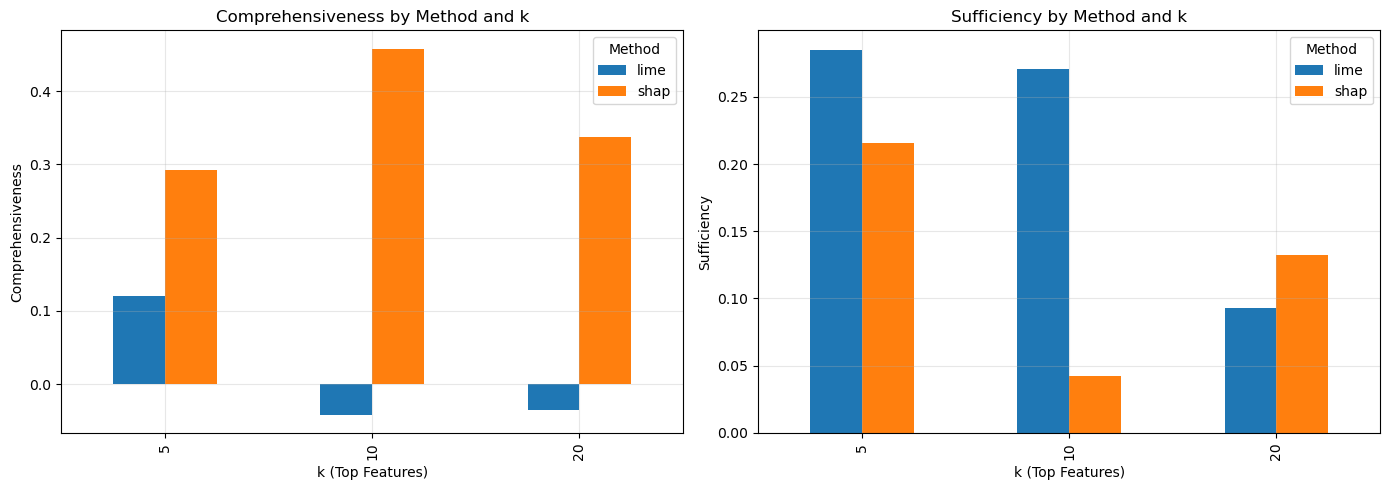


✅ Analysis Complete!


In [49]:
print("\n" + "="*60)
print("Final Analysis - Faithfulness, Quantitative, Comparison")
print("="*60)

# ============================================
# 1. Faithfulness 결과 분석
# ============================================
print("\n[1] Faithfulness Results")
print("-" * 40)

faith_results = pd.read_csv(f"{config.OUTPUT_DIR}/faithfulness_results.csv")
print(f"Loaded {len(faith_results)} faithfulness records")

print("\nBy Method and k:")
print(faith_results.groupby(["method", "k"])[
    ["comprehensiveness", "sufficiency", "log_odds_drop", "log_odds_keep"]
].mean().round(3))

print("\nBy Method, k, and Label:")
print(faith_results.groupby(["method", "k", "gold"])[
    ["comprehensiveness", "sufficiency"]
].mean().round(3))

# ============================================
# 2. Quantitative 결과 로드 및 분석
# ============================================
print("\n[2] Quantitative Analysis")
print("-" * 40)

# LIME 결과
lime_results = pd.read_csv(f"{config.OUTPUT_DIR}/lime_results_raw.csv")
print(f"LIME: {len(lime_results)} samples")



# SHAP 결과 (LIME과 동일하게 CSV에서 읽기)
shap_results = pd.read_csv(f"{config.OUTPUT_DIR}/shap_results_raw.csv")
print(f"SHAP: {len(shap_results)} samples")

# SHAP 결과 (pickle 파일들 병합)
import pickle
import glob

shap_files = glob.glob(f"{config.OUTPUT_DIR}/shap_cache/shap_batch_*.pkl")
shap_all = []
for file in shap_files:
    with open(file, "rb") as f:
        shap_all.extend(pickle.load(f))

print(f"SHAP: {len(shap_all)} samples")

# ============================================
# 3. 통계 검정
# ============================================
print("\n[3] Statistical Tests")
print("-" * 40)

from scipy.stats import ttest_rel, wilcoxon

for k in config.FAITHFULNESS_KS:
    dfk = (faith_results[faith_results['k'] == k]
           .pivot(index='i', columns='method', values='comprehensiveness')
           .dropna())
    
    if len(dfk) > 1:
        t_stat, t_p = ttest_rel(dfk['shap'], dfk['lime'])
        w_stat, w_p = wilcoxon(dfk['shap'], dfk['lime'])
        
        print(f"\nk={k}:")
        print(f"  SHAP mean: {dfk['shap'].mean():.4f}")
        print(f"  LIME mean: {dfk['lime'].mean():.4f}")
        print(f"  t-test: stat={t_stat:.4f}, p={t_p:.4e}")
        print(f"  Wilcoxon: stat={w_stat:.4f}, p={w_p:.4e}")

# ============================================
# 4. 시각화
# ============================================
print("\n[4] Generating Plots...")
print("-" * 40)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for metric, ax in zip(['comprehensiveness', 'sufficiency'], axes):
    data = faith_results.groupby(['method', 'k'])[metric].mean().unstack()
    data.T.plot(kind='bar', ax=ax)
    ax.set_title(f'{metric.capitalize()} by Method and k')
    ax.set_xlabel('k (Top Features)')
    ax.set_ylabel(metric.capitalize())
    ax.legend(title='Method')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/faithfulness_comparison.png', dpi=150)
print(f"✅ Saved: {config.OUTPUT_DIR}/faithfulness_comparison.png")
plt.show()

print("\n" + "="*60)
print("✅ Analysis Complete!")
print("="*60)

In [50]:
import pandas as pd
print("\n" + "=" * 60)
print("Quantitative Analysis - Post-processing from saved files")
print("=" * 60)
from tqdm import tqdm
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))
KEEP_WORDS = {"not", "no", "must", "should", "need", "cannot", "won't", "would", "could", "will"}
STOPWORDS = STOPWORDS - KEEP_WORDS

# ============================================
# 1. LIME 결과 처리
# ============================================
print("\n[1] Processing LIME results...")

lime_results = []
lime_all_tokens = []

# ✅ 저장된 LIME 원시 결과 읽기
lime_raw = pd.read_csv(f"{config.OUTPUT_DIR}/lime_results_raw.csv")

for idx, row in tqdm(lime_raw.iterrows(), total=len(lime_raw), desc="LIME Post-processing"):
    i = row['i']
    
    # ✅ FIX 1: 인덱스 범위 체크
    if i >= len(samples):
        print(f"⚠️ LIME {i}: Index out of range")
        continue
        
    txt = samples[i]

    # ✅ FIX 2: GPU 메모리 주기적 정리
    if idx % 1000 == 0:
        torch.cuda.empty_cache()

    # Prediction 정보
    probs = model_manager.predict([txt])[0]
    pred_idx = int(probs.argmax())
    predlab = model_manager.labels[pred_idx]
    goldlab = row['gold']
    is_correct = (predlab == goldlab)

    lime_results.append({
        "i": i,
        "gold": goldlab,
        "pred": predlab,
        "pred_prob": float(probs[pred_idx]),
        "is_correct": is_correct
    })

    # ✅ FIX 3: None 체크 + hasattr 체크
    exp = explanation_storage.get_lime(i)
    if exp is not None and hasattr(exp, 'as_list'):
        try:
            features = exp.as_list(label=pred_idx)
            feature_dict = {word.lower(): score for word, score in features}

            words = [w.lower() for w in word_tokens(txt)]
            word_counts = {}
            for w in words:
                if w in feature_dict:
                    word_counts[w] = word_counts.get(w, 0) + 1

            for word, count in word_counts.items():
                score = feature_dict[word]
                for _ in range(count):
                    lime_all_tokens.append({
                        "i": i,
                        "label": predlab,
                        "token": word,
                        "value": float(score),
                        "is_positive": score > 0,
                        "is_correct": is_correct
                    })
        except Exception as e:
            print(f"⚠️ LIME {i}: Cannot extract features - {e}")
    else:
        # ✅ exp가 None이거나 as_list 메서드가 없는 경우
        if exp is None:
            print(f"⚠️ LIME {i}: Explanation is None")
        else:
            print(f"⚠️ LIME {i}: Explanation has no 'as_list' method")

lime_df_results = pd.DataFrame(lime_results)
lime_df_tokens = pd.DataFrame(lime_all_tokens)

print(f"  LIME results: {len(lime_df_results)} samples")
print(f"  LIME tokens: {len(lime_df_tokens)} records")

# ============================================
# 2. SHAP 결과 처리
# ============================================
print("\n[2] Processing SHAP results...")

shap_results = []
shap_all_tokens = []

# ✅ 저장된 SHAP 배치 파일들 읽기
import pickle
import glob

shap_files = sorted(glob.glob(f"{config.OUTPUT_DIR}/shap_cache/shap_batch_*.pkl"))

for file in tqdm(shap_files, desc="SHAP Post-processing"):
    with open(file, "rb") as f:
        batch_data = pickle.load(f)

    for item in batch_data:
        i = item['i']
        
        # ✅ FIX 4: 인덱스 범위 체크
        if i >= len(samples):
            print(f"⚠️ SHAP {i}: Index out of range")
            continue
            
        tokens = item['tokens']
        values = np.array(item['values'])
        cls = item['pred_class']

        # ✅ FIX 5: pred_class 유효성 검증
        if cls < 0 or cls >= len(model_manager.labels):
            print(f"⚠️ SHAP {i}: Invalid pred_class={cls}")
            continue

        txt = samples[i]
        probs = model_manager.predict([txt])[0]
        predlab = model_manager.labels[cls]
        goldlab = data_loader.df.iloc[i][config.GOLD_COL]
        is_correct = (predlab == goldlab)

        shap_results.append({
            "i": i,
            "gold": goldlab,
            "pred": predlab,
            "pred_prob": item['pred_prob'],
            "is_correct": is_correct
        })

        # ✅ FIX 6: values 차원 체크
        if len(values.shape) == 2 and values.shape[1] > cls:
            for tok, val in zip(tokens, values[:, cls]):
                shap_all_tokens.append({
                    "i": i,
                    "label": predlab,
                    "token": tok,
                    "value": float(val),
                    "is_positive": val > 0,
                    "is_correct": is_correct
                })
        else:
            print(f"⚠️ SHAP {i}: Invalid values shape {values.shape}")

shap_df_results = pd.DataFrame(shap_results)
shap_df_tokens = pd.DataFrame(shap_all_tokens)

print(f"  SHAP results: {len(shap_df_results)} samples")
print(f"  SHAP tokens: {len(shap_df_tokens)} records")

# ============================================
# 3. Accuracy & Classification Report
# ============================================
print("\n[3] Computing Metrics...")

from sklearn.metrics import accuracy_score, classification_report

# ✅ FIX 7: 빈 데이터프레임 처리
if len(lime_df_results) > 0:
    lime_acc = accuracy_score(lime_df_results["gold"], lime_df_results["pred"])
    print(f"\nLIME Accuracy: {lime_acc:.3f}")
    print("\nLIME Classification Report:")
    print(classification_report(
        lime_df_results["gold"],
        lime_df_results["pred"],
        target_names=model_manager.labels,
        zero_division=0  # ✅ zero_division 경고 방지
    ))
else:
    print("\n⚠️ No LIME results to evaluate")

if len(shap_df_results) > 0:
    shap_acc = accuracy_score(shap_df_results["gold"], shap_df_results["pred"])
    print(f"\nSHAP Accuracy: {shap_acc:.3f}")
    print("\nSHAP Classification Report:")
    print(classification_report(
        shap_df_results["gold"],
        shap_df_results["pred"],
        target_names=model_manager.labels,
        zero_division=0  # ✅ zero_division 경고 방지
    ))
else:
    print("\n⚠️ No SHAP results to evaluate")

# ============================================
# 4. Token Frequency Analysis
# ============================================
print("\n[4] Token Frequency Analysis...")

# ✅ FIX 8: 안전한 집계 함수
def safe_token_summary(df_tokens, filter_correct=False, filter_positive=False):
    """빈 데이터프레임 처리가 포함된 안전한 집계"""
    if len(df_tokens) == 0:
        print("  ⚠️ Empty dataframe, skipping")
        return pd.DataFrame()
    
    filtered = df_tokens.copy()
    if filter_correct:
        filtered = filtered[filtered['is_correct'] == True]
    if filter_positive:
        filtered = filtered[filtered['is_positive'] == True]
    
    if len(filtered) == 0:
        print("  ⚠️ No data after filtering")
        return pd.DataFrame()
    
    summary = (
        filtered.groupby(["label", "token"])
        .agg(
            count=("token", "size"),
            avg_value=("value", "mean"),
            total_contribution=("value", "sum")
        )
        .reset_index()
        .sort_values(["label", "count"], ascending=[True, False])
    )
    
    # 필터링
    summary = summary[summary['token'].str.len() > 1]
    summary = summary[~summary['token'].str.lower().isin(STOPWORDS)]
    
    return summary

# SHAP - All tokens
print("  Processing SHAP all tokens...")
shap_summary_all = safe_token_summary(shap_df_tokens)

# SHAP - Positive only
print("  Processing SHAP positive tokens...")
shap_summary_positive = safe_token_summary(shap_df_tokens, filter_correct=True, filter_positive=True)

# LIME - All tokens
print("  Processing LIME all tokens...")
lime_summary_all = safe_token_summary(lime_df_tokens)

# LIME - Positive only
print("  Processing LIME positive tokens...")
lime_summary_positive = safe_token_summary(lime_df_tokens, filter_correct=True, filter_positive=True)

# ============================================
# 5. Save All Results
# ============================================
print("\n[5] Saving all results...")

# SHAP
shap_df_results.to_csv(f"{config.OUTPUT_DIR}/shap_prediction_results.csv", index=False)
shap_df_tokens.to_csv(f"{config.OUTPUT_DIR}/shap_token_records.csv", index=False)
shap_summary_all.to_csv(f"{config.OUTPUT_DIR}/shap_token_frequency_all.csv", index=False)
shap_summary_positive.to_csv(f"{config.OUTPUT_DIR}/shap_token_frequency_positive.csv", index=False)

# LIME
lime_df_results.to_csv(f"{config.OUTPUT_DIR}/lime_prediction_results.csv", index=False)
lime_df_tokens.to_csv(f"{config.OUTPUT_DIR}/lime_token_records.csv", index=False)
lime_summary_all.to_csv(f"{config.OUTPUT_DIR}/lime_token_frequency_all.csv", index=False)
lime_summary_positive.to_csv(f"{config.OUTPUT_DIR}/lime_token_frequency_positive.csv", index=False)

print(f"\n{'=' * 60}")
print("✅ All results saved!")
print(f"{'=' * 60}")
print(f"Output directory: {config.OUTPUT_DIR}/")
print(f"\nSaved files:")
print(f"  - shap_prediction_results.csv")
print(f"  - shap_token_records.csv ({len(shap_df_tokens):,} rows)")
print(f"  - shap_token_frequency_all.csv")
print(f"  - shap_token_frequency_positive.csv")
print(f"  - lime_prediction_results.csv")
print(f"  - lime_token_records.csv ({len(lime_df_tokens):,} rows)")
print(f"  - lime_token_frequency_all.csv")
print(f"  - lime_token_frequency_positive.csv")

# ============================================
# 6. Print Top Tokens
# ============================================
print("\n[6] Top 10 Tokens Preview...")

# ✅ FIX 9: 빈 데이터프레임 처리
if len(shap_summary_positive) > 0:
    print("\n[SHAP] Top tokens (correct predictions, positive only):")
    for label in model_manager.labels:
        subset = shap_summary_positive[shap_summary_positive['label'] == label].head(10)
        if len(subset) > 0:
            print(f"\n{label}:")
            print(subset)
        else:
            print(f"\n{label}: (No data)")
else:
    print("\n⚠️ No SHAP positive tokens to display")

if len(lime_summary_positive) > 0:
    print("\n[LIME] Top tokens (correct predictions, positive only):")
    for label in model_manager.labels:
        subset = lime_summary_positive[lime_summary_positive['label'] == label].head(10)
        if len(subset) > 0:
            print(f"\n{label}:")
            print(subset)
        else:
            print(f"\n{label}: (No data)")
else:
    print("\n⚠️ No LIME positive tokens to display")

print("\n" + "=" * 60)
print("✅ Quantitative Analysis Complete!")
print("=" * 60)


Quantitative Analysis - Post-processing from saved files

[1] Processing LIME results...


LIME Post-processing: 100%|██████████| 6/6 [00:00<00:00, 47.62it/s]


  LIME results: 6 samples
  LIME tokens: 285 records

[2] Processing SHAP results...


SHAP Post-processing: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


  SHAP results: 6 samples
  SHAP tokens: 285 records

[3] Computing Metrics...

LIME Accuracy: 0.833

LIME Classification Report:
              precision    recall  f1-score   support

         bug       1.00      1.00      1.00         2
 enhancement       0.67      1.00      0.80         2
    question       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


SHAP Accuracy: 0.833

SHAP Classification Report:
              precision    recall  f1-score   support

         bug       1.00      1.00      1.00         2
 enhancement       0.67      1.00      0.80         2
    question       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6


[4] Token Frequency Analysis...
  Processing SHAP all to